## Contents
* Line of sight analysis

###### by Umesh

In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
# import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'src' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

In [3]:
from parameters import *

In [4]:
# List number of bouts for each animal
print('mouse  bouts')
to=0
max_bouts = 0
for nickname in AllNames:
    tf = LoadTraj(nickname+'-tf')
    print(nickname+'     ',len(tf.no))
    
    if len(tf.no) > max_bouts:
        max_bouts = len(tf.no)
        
    to+=len(tf.no)
print('Total  ',to)

mouse  bouts
B1      104
B2      166
B3      147
B4      238
C1      173
C3      339
C6      150
C7      135
C8      164
C9      127
B5      245
B6      223
B7      204
D3      245
D4      319
D5      180
D6      59
D7      150
D8      109
D9      102
Total   3579


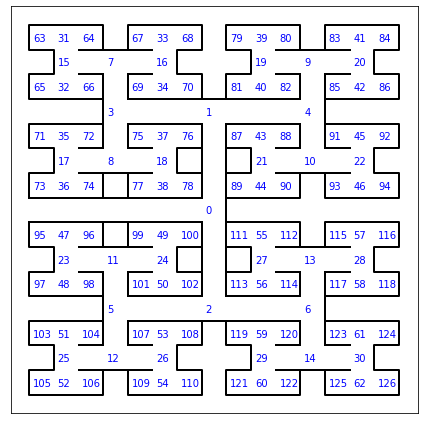

In [5]:
# Draw maze with node numbers
ma=NewMaze(6)
PlotMazeNodes(ma,figsize=6)

In [6]:
# define node numbers of all nodes
lv6_nodes = list(range(63,127))
lv5_nodes = list(range(31,63))
lv4_nodes = list(range(15,31))
lv3_nodes = list(range(7,15))
lv2_nodes = list(range(3,7))
lv1_nodes = list(range(1,3))
lv0_nodes = list(range(0,1))
lvl_dict = {0:lv0_nodes, 1:lv1_nodes, 2:lv2_nodes, 3:lv3_nodes, 4:lv4_nodes, 5:lv5_nodes, 6:lv6_nodes}

In [7]:
# inverse-define node numbers of all nodes mapped to depth
inv_lvl_dict = {n: level for level, nodes in lvl_dict.items() for n in nodes}
inv_lvl_dict[127] = -1   # home

#### Line of sight analysis

Out of 2 end nodes facing each other, the number of times one is visited **before** the other and analyze if the one being visited **first** while coming from a level 4 node is the one in line-of-sight.

In [8]:
left_nodes = dict.fromkeys(lv6_nodes[::2], 1)
right_nodes = dict.fromkeys(lv6_nodes[1::2], 1)

line_of_sight_left = np.array([63, 65, 71, 73, 95, 97, 103, 105, 79, 81, 87, 89, 111, 113, 119, 121])
line_of_sight_left_opp = line_of_sight_left + 1

line_of_sight_right = np.array([68, 70, 76, 78, 100, 102, 108, 110, 84, 86, 92, 94, 116, 118, 124, 126])
line_of_sight_right_opp = line_of_sight_right - 1

In [9]:
def los_path(n):
    path = []
    path.append(n)
    levels = 3
    while levels:
        if n%2 == 0:
            n -= 1
        n = n//2
        levels -= 1
        path.append(n)
    return tuple(path)[::-1]

In [10]:
los_path(65), los_path(66)

((7, 15, 32, 65), (7, 15, 32, 66))

In [11]:
los_path(69), los_path(70)

((7, 16, 34, 69), (7, 16, 34, 70))

In [12]:
def non_los_path(n):
    path = []
    path.append(n)
    levels = 2
    while levels:
        if n%2 == 0:
            n -= 1
        n = n//2
        levels -= 1
        path.append(n)
    return tuple(path + [path[1]+1 if path[1]%2 else path[1]-1])[::-1]

In [13]:
non_los_path(65), non_los_path(66)

((31, 15, 32, 65), (31, 15, 32, 66))

In [14]:
non_los_path(67), non_los_path(68)

((34, 16, 33, 67), (34, 16, 33, 68))

In [15]:
def get_all_valid_lospaths():
    valid_query_paths = {}
    for t in [line_of_sight_left, line_of_sight_left_opp, line_of_sight_right, line_of_sight_right_opp]:
        for n in t:
            p = los_path(n)
            if p in valid_query_paths:
                raise Exception(f'duplicate path for node {n}')
            valid_query_paths[p] = 1
    return valid_query_paths

In [16]:
def get_all_valid_nonlospaths():
    valid_query_paths = {}
    for t in [line_of_sight_left, line_of_sight_left_opp, line_of_sight_right, line_of_sight_right_opp]:
        for n in t:
            p = non_los_path(n)
            if p in valid_query_paths:
                raise Exception(f'duplicate path for node {n}')
            valid_query_paths[p] = 1
    return valid_query_paths

In [17]:
valid_lospaths = get_all_valid_lospaths()
valid_nonlospaths = get_all_valid_nonlospaths()

In [18]:
valid_lospaths

{(7, 15, 31, 63): 1,
 (7, 15, 32, 65): 1,
 (8, 17, 35, 71): 1,
 (8, 17, 36, 73): 1,
 (11, 23, 47, 95): 1,
 (11, 23, 48, 97): 1,
 (12, 25, 51, 103): 1,
 (12, 25, 52, 105): 1,
 (9, 19, 39, 79): 1,
 (9, 19, 40, 81): 1,
 (10, 21, 43, 87): 1,
 (10, 21, 44, 89): 1,
 (13, 27, 55, 111): 1,
 (13, 27, 56, 113): 1,
 (14, 29, 59, 119): 1,
 (14, 29, 60, 121): 1,
 (7, 15, 31, 64): 1,
 (7, 15, 32, 66): 1,
 (8, 17, 35, 72): 1,
 (8, 17, 36, 74): 1,
 (11, 23, 47, 96): 1,
 (11, 23, 48, 98): 1,
 (12, 25, 51, 104): 1,
 (12, 25, 52, 106): 1,
 (9, 19, 39, 80): 1,
 (9, 19, 40, 82): 1,
 (10, 21, 43, 88): 1,
 (10, 21, 44, 90): 1,
 (13, 27, 55, 112): 1,
 (13, 27, 56, 114): 1,
 (14, 29, 59, 120): 1,
 (14, 29, 60, 122): 1,
 (7, 16, 33, 68): 1,
 (7, 16, 34, 70): 1,
 (8, 18, 37, 76): 1,
 (8, 18, 38, 78): 1,
 (11, 24, 49, 100): 1,
 (11, 24, 50, 102): 1,
 (12, 26, 53, 108): 1,
 (12, 26, 54, 110): 1,
 (9, 20, 41, 84): 1,
 (9, 20, 42, 86): 1,
 (10, 22, 45, 92): 1,
 (10, 22, 46, 94): 1,
 (13, 28, 57, 116): 1,
 (13, 28, 5

In [19]:
valid_nonlospaths

{(32, 15, 31, 63): 1,
 (31, 15, 32, 65): 1,
 (36, 17, 35, 71): 1,
 (35, 17, 36, 73): 1,
 (48, 23, 47, 95): 1,
 (47, 23, 48, 97): 1,
 (52, 25, 51, 103): 1,
 (51, 25, 52, 105): 1,
 (40, 19, 39, 79): 1,
 (39, 19, 40, 81): 1,
 (44, 21, 43, 87): 1,
 (43, 21, 44, 89): 1,
 (56, 27, 55, 111): 1,
 (55, 27, 56, 113): 1,
 (60, 29, 59, 119): 1,
 (59, 29, 60, 121): 1,
 (32, 15, 31, 64): 1,
 (31, 15, 32, 66): 1,
 (36, 17, 35, 72): 1,
 (35, 17, 36, 74): 1,
 (48, 23, 47, 96): 1,
 (47, 23, 48, 98): 1,
 (52, 25, 51, 104): 1,
 (51, 25, 52, 106): 1,
 (40, 19, 39, 80): 1,
 (39, 19, 40, 82): 1,
 (44, 21, 43, 88): 1,
 (43, 21, 44, 90): 1,
 (56, 27, 55, 112): 1,
 (55, 27, 56, 114): 1,
 (60, 29, 59, 120): 1,
 (59, 29, 60, 122): 1,
 (34, 16, 33, 68): 1,
 (33, 16, 34, 70): 1,
 (38, 18, 37, 76): 1,
 (37, 18, 38, 78): 1,
 (50, 24, 49, 100): 1,
 (49, 24, 50, 102): 1,
 (54, 26, 53, 108): 1,
 (53, 26, 54, 110): 1,
 (42, 20, 41, 84): 1,
 (41, 20, 42, 86): 1,
 (46, 22, 45, 92): 1,
 (45, 22, 46, 94): 1,
 (58, 28, 57, 11

In [35]:
def _count_los_visits_per_mouse(nickname, valid_query_paths):
    first_visit_endnode_counts = dict.fromkeys(lv6_nodes, 0)
    tf = LoadTraj(nickname+'-tf')
    for i, bout in enumerate(tf.no):
        path = [node for node, _ in bout]
        for j in range(len(path)):
            query_path = tuple(path[j:j+4])
            if len(query_path) < 3:
                break
            if valid_query_paths.get(query_path, None):
                first_visit_endnode_counts[query_path[-1]] += 1
    return first_visit_endnode_counts

In [44]:
def count_los_visits(paths):
    first_visit_endnode_counts_mouse = defaultdict(dict)
    for nickname in AllNames:
        first_visit_endnode_counts_mouse[nickname] = _count_los_visits_per_mouse(nickname, paths)
    return first_visit_endnode_counts_mouse

In [45]:
def get_left_points(counts):
    lpoints = [[], []]
    for l, r in zip(line_of_sight_left, line_of_sight_left_opp):
        l_, r_ = counts[l], counts[r]
        if l_+r_:
            x, y = l, (l_*100)/(l_+r_)
        else:
            x, y = l, 0
        lpoints[0].append(x)
        lpoints[1].append(y)
    return lpoints

In [46]:
def get_right_points(counts):
    rpoints = [[], []]
    for r, l in zip(line_of_sight_right, line_of_sight_right_opp):
        r_, l_ = counts[r], counts[l]
        if r_+l_:
            x, y = r, (r_*100)/(r_+l_)
        else:
            x, y = r, 0
        rpoints[0].append(x)
        rpoints[1].append(y)
    return rpoints

In [65]:
def plot_los_preferences(first_visit_endnode_counts_mouse):
    first_visit_lospath_counts_mouse = count_los_visits(valid_lospaths)
    first_visit_nonlospath_counts_mouse = count_los_visits(valid_nonlospaths)
    los_preference_avg_los = defaultdict(int)
    los_preference_avg_nonlos = defaultdict(int)
    for nickname in AllNames:
        first_visit_lospath_counts = first_visit_lospath_counts_mouse[nickname]
        first_visit_nonlospath_counts = first_visit_nonlospath_counts_mouse[nickname]

        fig, axes = plt.subplots(1, 2)

        lpoints = get_left_points(first_visit_lospath_counts)
        axes[0].plot(lpoints[0], lpoints[1], 'b*', label = 'left')
        axes[0].set_title(f"Mouse {nickname}: coming from L3")
        axes[0].set_ylabel('% preference')
        axes[0].set_xlabel('end node number')
        axes[0].set_ylim([0,100])
        
        rpoints = get_right_points(first_visit_lospath_counts)
        axes[0].plot(rpoints[0], rpoints[1], 'g*', label='right')
        
        los_preference_avg_los[nickname] = np.mean(lpoints[1] + rpoints[1])

        
        lpoints = get_left_points(first_visit_nonlospath_counts)
        axes[1].plot(lpoints[0], lpoints[1], 'b*', label = 'left')
        axes[1].set_title(f"Mouse {nickname}: coming from L5opp")
        axes[1].set_ylabel('% preference')
        axes[1].set_xlabel('end node number')
        axes[1].set_ylim([0,100])
        
        rpoints = get_right_points(first_visit_nonlospath_counts)
        axes[1].plot(rpoints[0], rpoints[1], 'g*', label='right')
        
        los_preference_avg_nonlos[nickname] = np.mean(lpoints[1] + rpoints[1])

#         axes.plot([60, 130], [60, 60], 'r-')

        plt.legend()
        plt.show()
    return los_preference_avg_los, los_preference_avg_nonlos

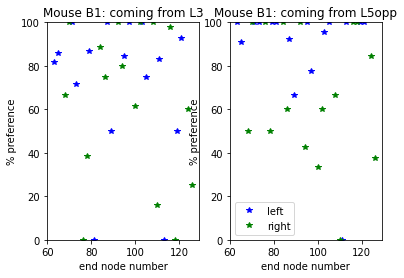

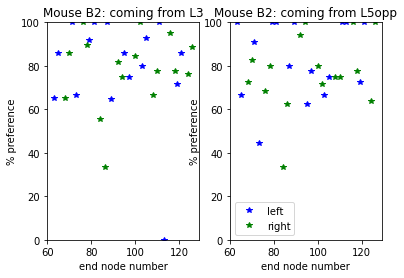

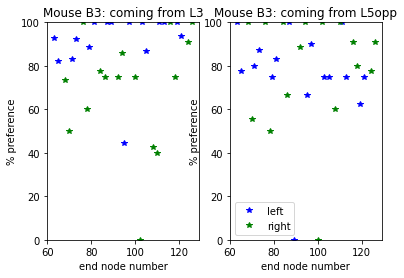

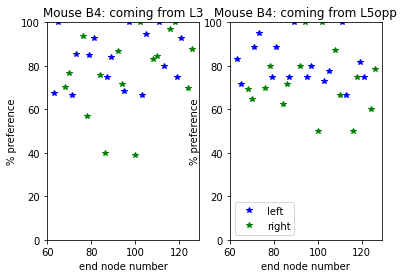

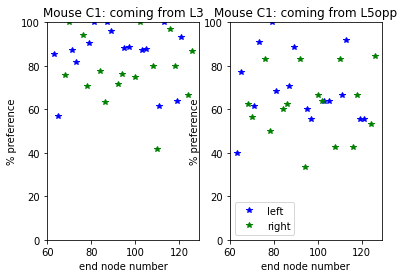

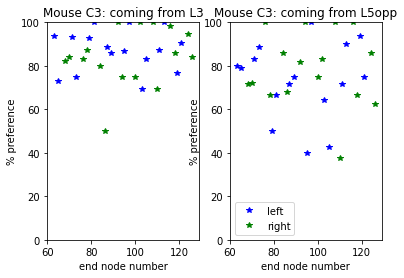

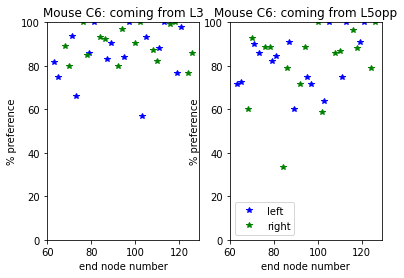

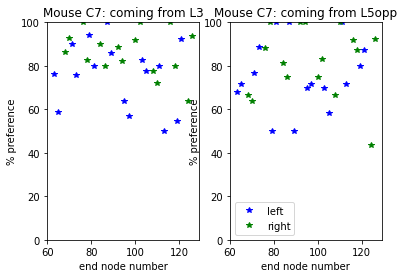

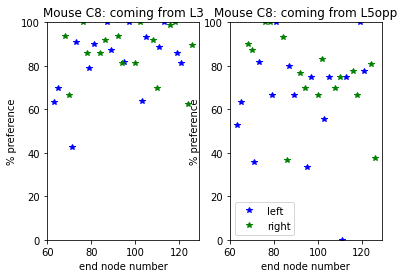

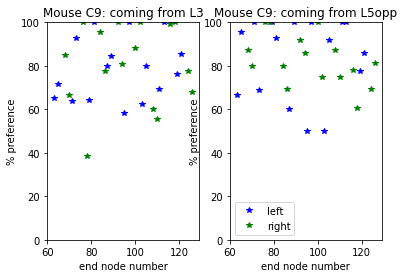

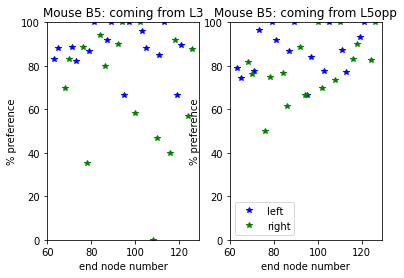

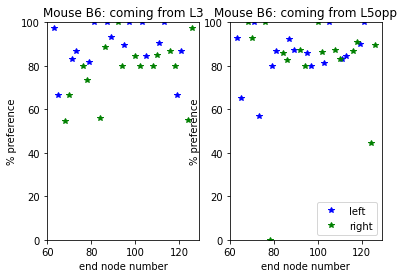

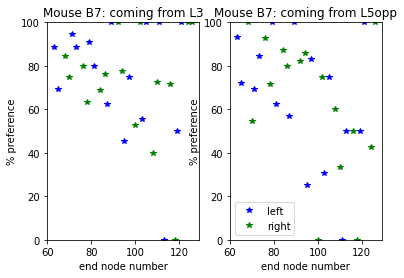

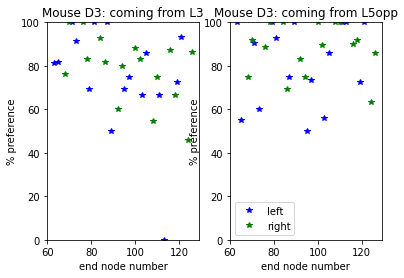

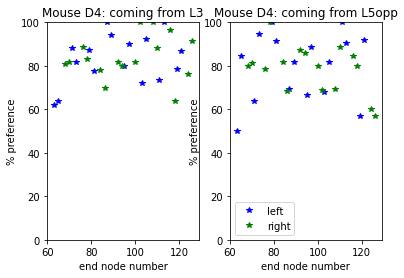

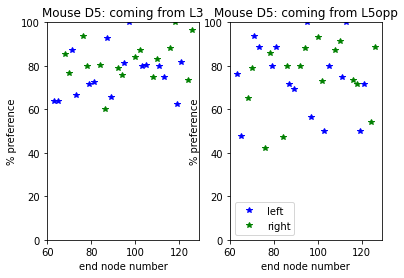

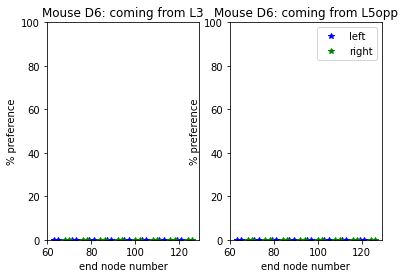

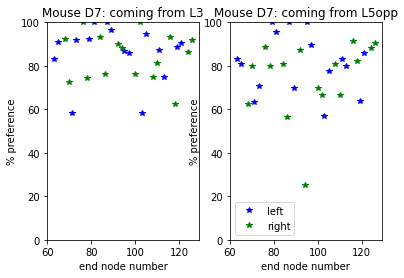

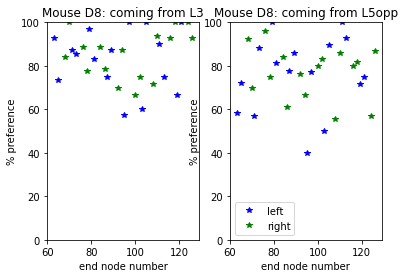

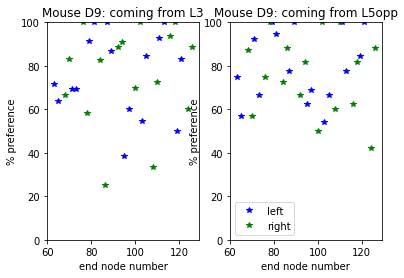

In [66]:
first_visit_endnode_counts_mouse = count_los_visits(valid_lospaths)
los_preference_avg_los, los_preference_avg_nonlos = plot_los_preferences(first_visit_endnode_counts_mouse)

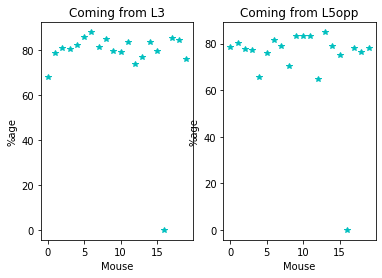

In [64]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(range(0, 20),los_preference_avg_los.values(), 'c*')
# axes[0].xticks(ticks=np.arange(0,20), labels=AllNames)
axes[0].set_xlabel('Mouse')
axes[0].set_ylabel('%age')
axes[0].set_title('Coming from L3')

axes[1].plot(range(0, 20),los_preference_avg_nonlos.values(), 'c*')
# axes[1].xticks(ticks=np.arange(0,20), labels=AllNames)
axes[1].set_xlabel('Mouse')
axes[1].set_ylabel('%age')
axes[1].set_title('Coming from L5opp')
plt.show()

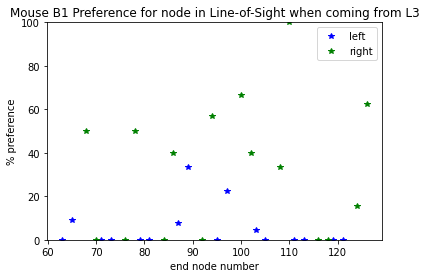

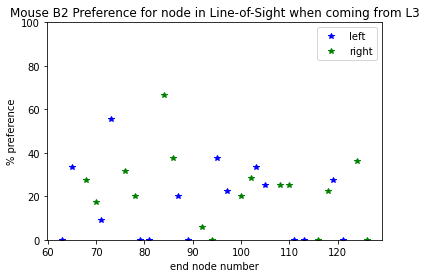

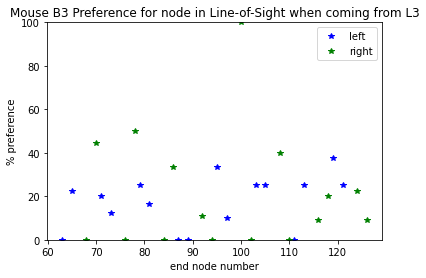

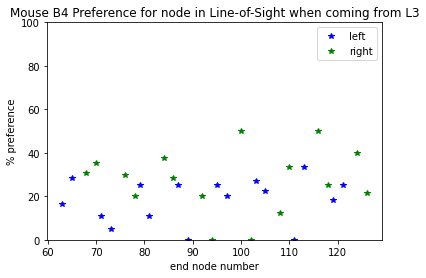

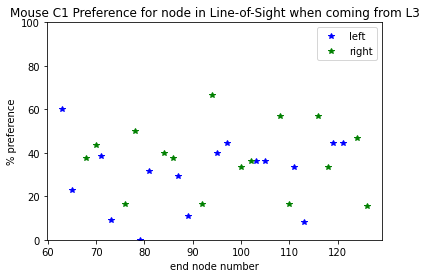

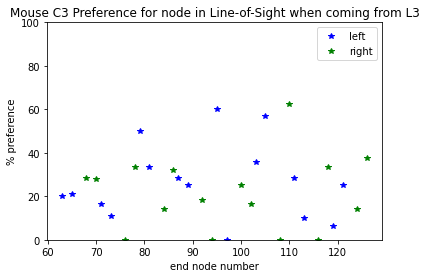

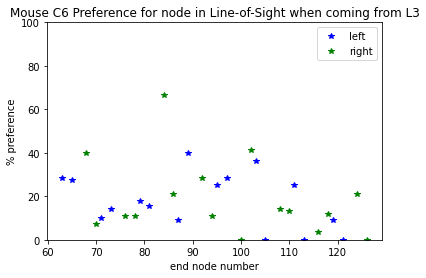

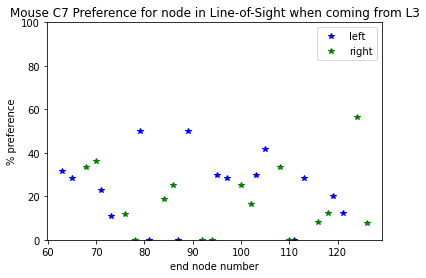

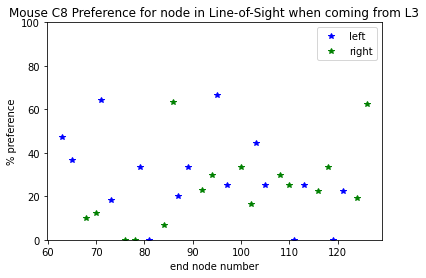

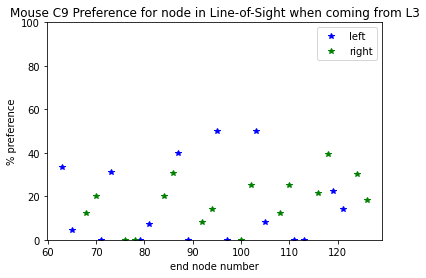

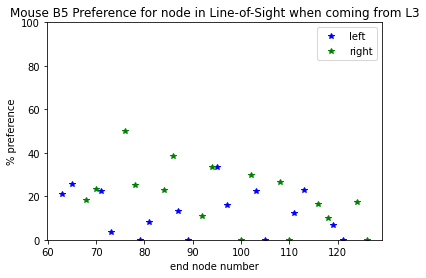

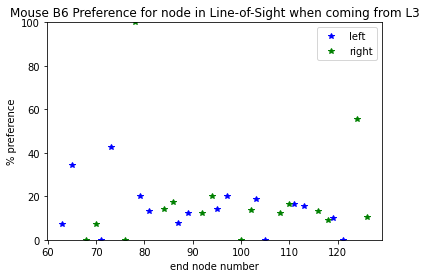

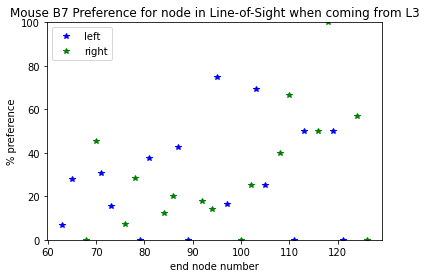

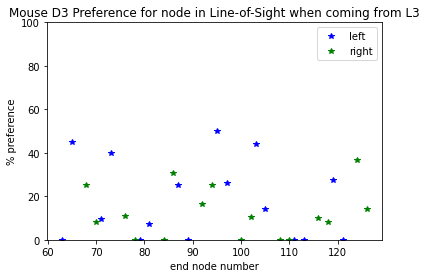

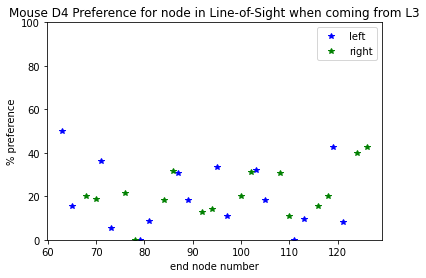

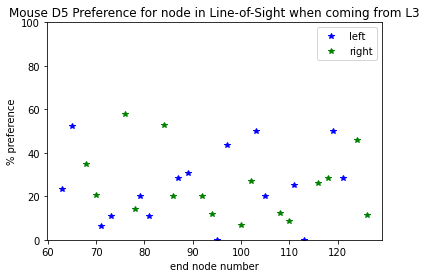

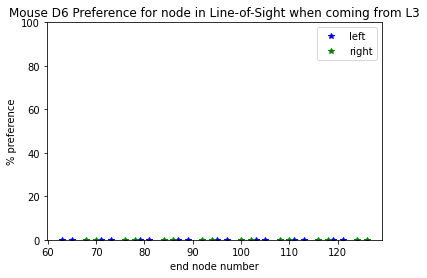

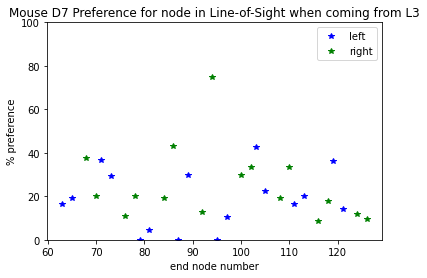

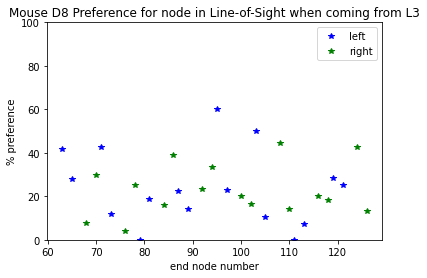

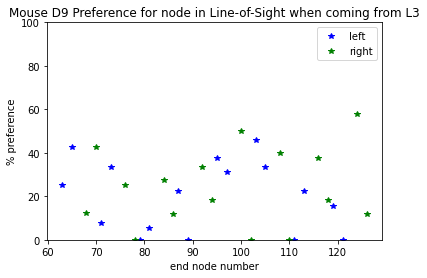

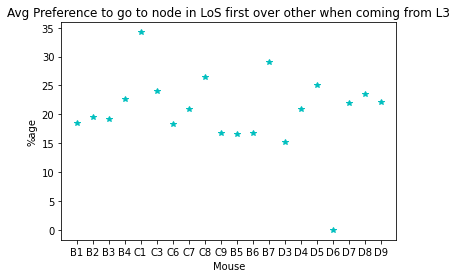

In [43]:
first_visit_endnode_counts_mouse = count_los_visits(valid_nonlospaths)
los_preference_avg = plot_los_preferences(first_visit_endnode_counts_mouse)

plt.plot(range(0, 20),los_preference_avg.values(), 'c*')
plt.xticks(ticks=np.arange(0,20), labels=AllNames)
plt.xlabel('Mouse')
plt.ylabel('%age')
plt.title('Avg Preference to go to node in LoS first over other when coming from L3')
plt.show()